# Sentiment Analaysis

Sentiment analaysis(text-classification) using DistillBert.

We'll cover,
    1. Datasets --> Load and process datasets
    2. Tokenizers --> Tokenize input text
    3. Transformers --> Load models, train and infer
    4. Datasets --> Load metrics and evaluate models

## The Dataset

To build our emotional detectors, we're gonna use an article that explored how emotions are represented in English Twitter messages. This datasets contains six-basic emotions: anger, disgust, fear, joy, sadness and surprise.

Given a tweet, we've to train a model that can classify into one of these emotions.

### First look at Hugging Face Datasets

`list_datasets()` from `datasets` will list all dataset available in Hub.

In [1]:
!pip install transformers torch datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 123.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 18.4 MB/s eta 0:00:00


In [2]:
from datasets import list_datasets

all_datasets = list_datasets()

In [3]:
type(all_datasets)

list

In [4]:
print(f"There are {len(all_datasets)} in hub")
print(f"The first 10 are: a{all_datasets[:10]}")

There are 39979 in hub
The first 10 are: a['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


`list_datasets()` returns the list of datasets names available in Hub.
`load_dataset()` loads a dataset based on dataset name.

Let's load the `emotion` dataset.

In [5]:
from datasets import load_dataset
emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
type(emotions)

datasets.dataset_dict.DatasetDict

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

We've three splits --> train, validation and test and for each split we've the features of dataset in `features` and total samples in `num_rows`.

We can access the different splits of data like accessing a key in dict.

In [8]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [9]:
type(train_ds)

datasets.arrow_dataset.Dataset

Each item in DatasetDict is Dataset. Dataset behaves similar to ordinary Python array or list.

In [10]:
len(train_ds)

16000

In [11]:
# Let's look at a single sample
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [12]:
# Column names
train_ds.column_names

['text', 'label']

The keys correspond to column names. This reflect that Datsets is base on `Apache arrow` which defines an typed columnar format that is more efficient than native Python.

What are the datatypes used by each column can be accessed under `features` attribute of an `Dataset` object.

In [13]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [14]:
train_ds.features['label']

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

Datatype of `text` is `string` while `label` column is special `ClassLabel `object that contains information about the class names and their mapping to integers.

In [15]:
# Slicing dataset
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


### What if dataset is not on the hub?

In many cases. We'll be working with data in laptop or remote server in an organization. Datasets provides several loading script so handle local and remote datasets.

* To load csv --> ```load_dataset("csv", data_files="my_file.csv")```
* To load text --> ```load_dataset("text", data_files="my_file.txt")```
* To load json --> ```load_dataset("json", data_files="my_file.json")```

Just pass the format and file, also we can pass an url of the file to data_files param.

In [16]:
# Let's load emotion data from it's source.
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"

In [17]:
# Let's get the file
!wget {dataset_url}

--2023-06-10 12:42:19--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 18.160.249.9, 18.160.249.78, 18.160.249.31, ...
Connecting to huggingface.co (huggingface.co)|18.160.249.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   1.58M  --.-KB/s    in 0.1s    

2023-06-10 12:42:30 (13.5 MB/s) - ‘train.txt’ saved [1658616/1658616]



In [18]:
# Let's look at top few lines of this file
!cat train.txt | head -n5

i didnt feel humiliated;sadness
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake;sadness
im grabbing a minute to post i feel greedy wrong;anger
i am ever feeling nostalgic about the fireplace i will know that it is still on the property;love
i am feeling grouchy;anger


The data is similar to a csv file with no headers. Text seperated by emotion.
Let's load this.

In [19]:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-1adc62f4ea58656c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
emotions_local["train"][:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': ['sadness', 'sadness', 'anger', 'love', 'anger']}

For more read [Datasets documentation](https://huggingface.co/docs/datasets/index)

### From Datasets to DataFrames

Although datasets provide a lot of low-level funtionality to slice and dice our data. Let's convert this to pandas DataFrame to leverage it's high-level api's to visualize data.

In [21]:
import pandas as pd

emotions.set_format(type="pandas")
train_df = emotions["train"][:]
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [22]:
# The labels are present as integers, 
# let's write a funiton to conver them to strings
# features ClassLabels has int2str function returns string of labels based on index
print(f"All Labels: {emotions['train'].features['label']}")
print(f"Label of int 0: {emotions['train'].features['label'].int2str(0)}")

All Labels: ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)
Label of int 0: sadness


In [23]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

In [24]:
train_df["label_name"] = train_df["label"].apply(label_int2str)
train_df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Before we dive into training the classifier, let's get one with the data.

## Become one with the data

### Class distribution

Based on the class distribtution, a classification problem can be divided into balanced and imbalance classification problems

In [25]:
import matplotlib.pyplot as plt
train_df["label_name"].value_counts(ascending=True)

surprise     572
love        1304
fear        1937
anger       2159
sadness     4666
joy         5362
Name: label_name, dtype: int64

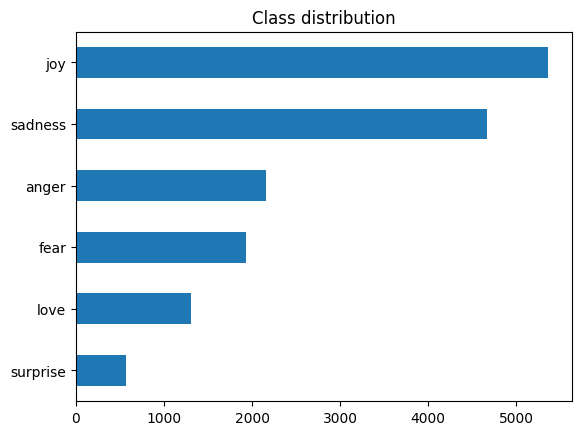

In [26]:
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Class distribution");

In [27]:
(train_df["label_name"].value_counts(ascending=True) / len(train_df)) * 100

surprise     3.57500
love         8.15000
fear        12.10625
anger       13.49375
sadness     29.16250
joy         33.51250
Name: label_name, dtype: float64

Looking at te data percentages, `joy` and `sadness` appear more frequently whereas `surprise` and `love` are much rare.

We can deal with imbalance classed by,
    * Oversampling minority class
    * Undersampling majority class
    * Gather more lablelled data from underpresented classes.

[My blog on imblearn techniques](https://jpchii.github.io/2021/03/23/strokeprediction-imbalanced-binary-classification.html)

In this notebook, we'll use the dataset as is.

### How long are the tweets?

Transformer models have a maximum input sequence length that is referred to as `maximum context size`. For DistillBERT the maximum context size is 512 tokens,which is few paragraphs of text.

Tokens are an atomic piece of text, tokens can be word, character, sub-word. For now we'll treat a token as a single word.

Let's look at number of words per tweet.

In [28]:
train_df["words_per_tweet"] = train_df["text"].str.split().apply(len)
train_df.head()

,text,label,label_name,words_per_tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


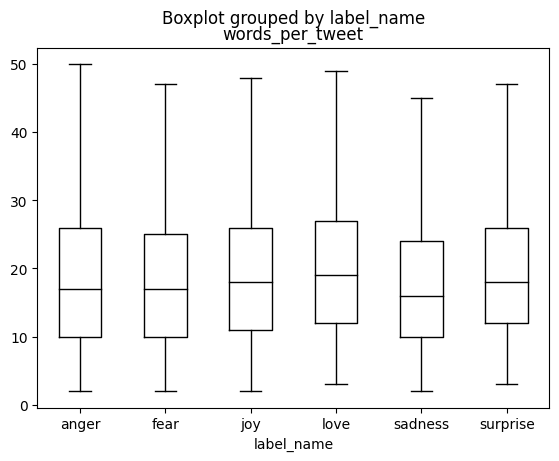

In [29]:
# Let's visualize the lenght of words
train_df.boxplot(
    column="words_per_tweet", # Column to plot,
    by="label_name", # column to beplotted with respect to lebel_name
    grid=False,
    showfliers=False,
    color="black",
);

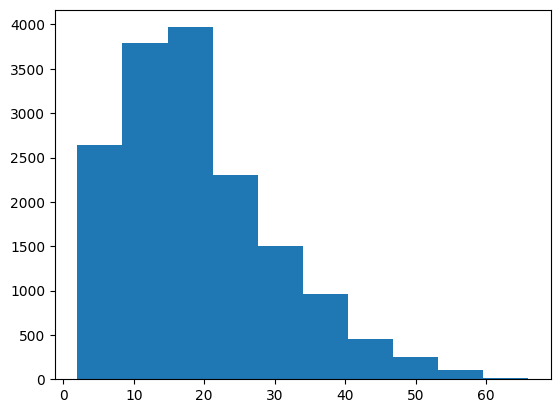

In [30]:
# Let's check the distribution of number of words
plt.hist(train_df["words_per_tweet"]);

In [31]:
import numpy as np
np.percentile(a=train_df["words_per_tweet"], q=75)

25.0

From the boxplot we can see most tweets are around 15 words long and the longest tweets are well below maximum context size of DistillBERT.

In case of texts longer than maximum context size, they need to be truncated and if there's some important information in truncated text this will lead to a loss of performance.

We've explored the data enough. Let's reset Format of Dataset and proceed with conversion of text to numbers.

In [32]:
emotions.reset_format()

## From Text to Tokens

As with all machine learing models or neural networks, transoformers too can't process raw string. It assumes or expects the input to be `tokenized` and `encoded` as numerical vetors.

Tokenization is the process of splitting a passage into suitable unit(word, character, sub-word) and then convert them to a learnable representation(vectors).

Since DistillBERT is a pretrained model, it will have a Tokenizer in hub. Even if not the tokenization stratergy depends on the corpus.

Let's explore `character` and `word` tokenization.

### Character Tokenization

Simplest tokenization scheme is to feed each character individaully to the model.
In Python `str` objects are really arrays under the hood which makes it easier to implement character level tokenization.

In [33]:
text = "Character level Tokenization."
tokenized_text = list(text)
print(tokenized_text)

['C', 'h', 'a', 'r', 'a', 'c', 't', 'e', 'r', ' ', 'l', 'e', 'v', 'e', 'l', ' ', 'T', 'o', 'k', 'e', 'n', 'i', 'z', 'a', 't', 'i', 'o', 'n', '.']


Next we've to convert the characters to integers. This proess is sometimes called `numericalization`.

In [34]:
stoi = {s:i for i, s in enumerate(sorted(set(tokenized_text)))}
stoi

{' ': 0,
 '.': 1,
 'C': 2,
 'T': 3,
 'a': 4,
 'c': 5,
 'e': 6,
 'h': 7,
 'i': 8,
 'k': 9,
 'l': 10,
 'n': 11,
 'o': 12,
 'r': 13,
 't': 14,
 'v': 15,
 'z': 16}

In [35]:
# Let's use this to conver input text to integers
input_ids = [stoi[token] for token in tokenized_text]
print(input_ids)

[2, 7, 4, 13, 4, 5, 14, 6, 13, 0, 10, 6, 15, 6, 10, 0, 3, 12, 9, 6, 11, 8, 16, 4, 14, 8, 12, 11, 1]


Each token has been mapped to a unique numerical identifier, hence the name `input_ids`. Let's conver this to 2D tensor of one-hot vectors.

One-hot vecotrs are frequently used in machine learning to encode categorical data.

Let's try this out with naruto series characters.

In [36]:
categorical_df = pd.DataFrame(
    {"Name": ["Naruto", "Sasuke", "Sakura"], "Label ID": [0, 1, 2]}
)
categorical_df

,Name,Label ID
0,Naruto,0
1,Sasuke,1
2,Sakura,2


Machine learning models can easily learn the ordeing in above data. Let's create a column for each cateogry and turn them on(1) where it's the actual class. This is essentially one-hot vectors.

In [37]:
pd.get_dummies(categorical_df["Name"])

,Naruto,Sakura,Sasuke
0,1,0,0
1,0,0,1
2,0,1,0


In [38]:
pd.get_dummies(categorical_df["Name"], dtype=float)

,Naruto,Sakura,Sasuke
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0


We've a similar ordinal probelm with `input_ids`. Adding or subracting IDs (occurs inside a neural network) is a meaningless operations. Since the results is a snew ID that represents another random token.

On the other addition of two one-hot vectors enable those two postions, resulting that co-occur.

Let's implement this.

In [39]:
import torch
from torch.nn import functional as F

In [40]:
input_ids = torch.tensor(input_ids)
one_hot_encoding = F.one_hot(input_ids)
print(f"Vocab size: {len(stoi)}")
print(f"Number of tokens in input text: {len(input_ids)}")
print(f"One hot encoding shape: {one_hot_encoding.shape}")
print(f"Tokenized text id's: {input_ids[:5]}")
print(f"Few one hot vectors: {one_hot_encoding[:5]}")

Vocab size: 17
Number of tokens in input text: 29
One hot encoding shape: torch.Size([29, 17])
Tokenized text id's: tensor([ 2,  7,  4, 13,  4])
Few one hot vectors: tensor([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


We've a 16 dimension input for 28 input_ids.

We can see one-hot vetors are turned on the indexes of input_ids.

> It's good to specify `num_classes` in `one_hot()` function. Sometimes they might end up shorter than the length of vocabulary.

Character tokenization helps with word misspleeing and rare words but learning words from this tokenization involves heavy compute, memory and data. Hence this is rarely used in pracice. Instead we can use `Word tokenization`.

### Word Tokenization

By splitting words and mapping each word to an integer enables the model to skip the step of learning words from characters. Thereby reduces the complexity of the training process.

One simple class of word tokenizers uses whitespace to tokenize the text. Let's do this by applying Python's `split()` directly on raw text.

In [41]:
word_tokenized_text = text.split()
print(word_tokenized_text)

['Character', 'level', 'Tokenization.']


From here we can use the same steps as character embeddings.

We already have a potential probelem wit the tokenization scheme: punctuation is not accounted for, so `Tokenization.` is treated as a single token.

Given the words can include declinations, conjugations or misspellings, the size of vocabulary can easily grow into millions!

> Note: Some word tokenizers have extra rules for punctuation. One can also apply stemming or lemmatization, which normalizes words to their stem(e.g great, greater and greatest all become great) at the expense of losing some information in the text.

Having a large vocabulary is a problem becuase it requires neural networks to have enormous number of parameters.

Let's say our vocab is 1million unique words and we want to vectorize them to a thousand-dimension. The number of parameters will be 1million x 1thousand = 1 billion weights. This is already comparable to largest GPT-2 model which has around 1.5 billion parameters in total!

Naturally, we want to avoid wasteful with our model paramters since its expensive to train and maintain larger models.

We'll take the top 100,000 most common words in corpus, discard rare words and assing `UNK` token to other words. This means we loose some information as model has no information associated with `UNK`.

*subword tokenization* --> Is between character and word tokenization. Preserves all input information and some of the input structure.

### Subword Tokenization

The basic idea behing subword tokenization is to combine the best aspects of character and word tokenization. We want to split rare or mispelled words into smaller units so the model can deal with it. Also we want to keep frequent words as unique entities.

*The main **distinguishing feature** of subword tokenization is learned from the pretraining corpus using a mix of staistical rules and algorithms*.

Let's start with *WordPiece* Subword Tokenzer used by BERT an DistillBERT.

`AutoTokenizer` class from Transformers load the tokenizer associated with the model by providing the model ID on the Hub.

In [42]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

`AutoTokenizer` class belongs to a larger set of [auto classes](https://huggingface.co/docs/transformers/model_doc/auto) whose job is to automatically retrieve the model's configuration, pretrained weights or vocabulary from the name of the checkpoint.

Also we can load the specific tokenizer as well without Auto classes.

In [43]:
from transformers import DistilBertTokenizer

distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
distilbert_tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [44]:
# Let's examine the tokenizer
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 2839, 2504, 19204, 3989, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


We've arrived at `input_ids` like we got in tokenization.

Let's use `convert_ids_to_tokens()` method.

In [45]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text["input_ids"])
print(tokens)

['[CLS]', 'character', 'level', 'token', '##ization', '.', '[SEP]']


All tokeizer will mostly have start and end tokens, here it's `[CLS]` and `[SEP]`. Rare word like tokenization is split into `token` and `##ization`. Token with prefix `##` needs to be merged with previous token while converting id's to string.

In [46]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] character level tokenization. [SEP]


Let's look at some of the `AutoTokenizer` attributes

In [47]:
# Vocab size
tokenizer.vocab_size

30522

In [48]:
# Model max length
tokenizer.model_max_length

512

In [49]:
# Model input names
tokenizer.model_input_names

['input_ids', 'attention_mask']

Let's tokenize the whole dataset!

> Warning: With Pretrained models use the same tokenzier used by the model, else the model might not perform well as it's something else than what it was trained on.

### Tokenizing the Whole Dataset

We'll use `map()` function of our `DatasetDict` object to apply a processing function to each element in our dataset. This method also allows us to create new rows and columns.

In [50]:
# Function to tokenize
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

* `padding=True` --> Pada examples with zeros to the size of the longest one in a batch,
* `truncation=True` --> Truncate examples to model's maximum context size.

In [51]:
# Let's tokenize
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


First sample has lot's of zeros, padding to make them the same length as second text. 0 corresponds to `[PAD]` token in the vocabulary.

In [52]:
# Special tokens
token2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
token2ids

[('[UNK]', 100), ('[SEP]', 102), ('[PAD]', 0), ('[CLS]', 101), ('[MASK]', 103)]

In [53]:
data = sorted(token2ids, key=lambda x: x[-1])
special_tokens_df = pd.DataFrame(data)
special_tokens_df

,0,1
0,[PAD],0
1,[UNK],100
2,[CLS],101
3,[SEP],102
4,[MASK],103


In [54]:
# Let's visualize attention masks
tokenized_inputs = tokenize(emotions["train"][:10])

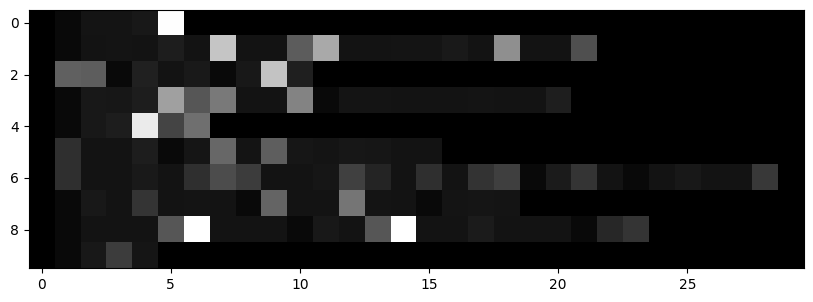

In [55]:
plt.figure(figsize=(10, 7))
plt.imshow(tokenized_inputs["input_ids"], cmap="gray");

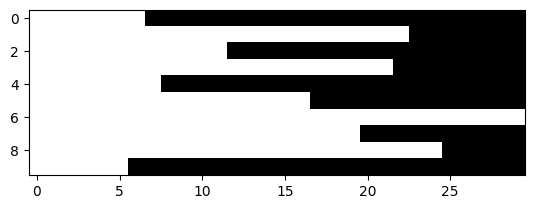

In [56]:
plt.imshow(tokenized_inputs["attention_mask"], cmap="gray");

We can see the attention mask is disabled for padding(0's) in input_ids.
Since we already know there's nothing to learn with padding tokens, attention mask is used to inform this to mode.

*Attention mask*
![alt attention masks](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/2-text-classification/attention-mask.png?raw=1)

In [57]:
# Tokenize entire dataset
emotions_encoded = emotions.map(
    tokenize, # Function to map to each item
    batched=True,
    batch_size=None
)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

With `batched=True` and `batch_size=None` entire dataset is considerd as a single batch, this ensures input_ids and attention_masks have the same shape globally.

In [58]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


> Note: We'll see *data collators* usage to dyanamically pad batches. Padding globally will help us in exracting a feature matrix from the whole corpus.

## Training a Text Classifer

DistillBERT are pretrained to predict masked words in a sequence of text. We can't use these language models directly for text classification. We've modify the model slightly, To do that let's look at the architecture of an encoder-based model like DistillBERT

*sequence classification architecture with an encoder-based transformer. It has model's pretrained body combined with a custom classification head.*
![alt architecture](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/2-text-classification/distillbert.png?raw=1)

Steps in training:
1. *token encodings* --> Text is tokenized and represent as one-hot vectors.
2. *token embeddings* --> encodings are converted to vectors in a lower-dimensional space.
3. token embeddings are passed through encoder stack and return hidden states for each token.
4. For pretraining objective each hidden state is fed to a layer to predict the masked token.
5. For a classification task, we repace the language modelling layer with a classification layer.

> Note: In Practive, we can skip the one hot token encoding, as it's jus picking the embedding for the turned on position. Instead we can just fetch the column with token ID from the matrix. Like we did in makemore series.

We've two options:
1. *Feature extraction* --> Freeze the features and train a classifierwithout modifying the pretrained mode
2. *Fine-tuning* --> Unfreeze all layer in pretrained model and trainthe entire model end-to-end updating the params of the pretrained model.


### Transformers as Feature Extractors

We'll freeze the body's weights during training and use the hidde weights as features for a classifer. This will create a small or shallow model. Training is quick and If GPU's are unavailable this method is efficient as hidden states need to be precomputed once.


#### Using pretrained models

We'll use another auto class from transformers called `AutoMOdel` to load the weight of DistillBERT model using `from_prerained()`

In [59]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We've also made the code device code agnostice by moving the model to compute device.

#### Extracting the last hidden states

Let's retrive the last hidden states for a single string.

In [60]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [61]:
text = "this is a test"
inputs = tokenizer(text=text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].shape}")

Input tensor shape: torch.Size([1, 6])


Resulting tensor has the shape `[batch_suze, n_tokens]`

In [62]:
# Place the encoding in device
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


Depending on model configuration, the output can contain several objects, such as hidden states, losses or attentions.

In out cae, model output is an isntance of `BaseModelOuput` and we can access it's attributes by it's name.

In [63]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

We've a 768 dimension hidden state for each input_id. hidden_state shape `[batch_size, n_tokens, hidden_dim]`,

For classificaiton tasks, it's common practice to just use the hidden state associated with the `[CLS]` token as the input feature.

In [64]:
outputs.last_hidden_state[:, 0, :].shape, outputs.last_hidden_state[:,0].shape

(torch.Size([1, 768]), torch.Size([1, 768]))

In [65]:
# The [CLS] token will be the first token in a encoded string of input_ids.
# Get the hidden state of first token
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

Now we know how to get the last hidden state for a single string. Let's wrap this in a function and use `map()` to add additional column to `DatasetDict` with hidden states of all tweets,

In [66]:
def extract_hidden_states(batch):
    # Move inputs to GPU
    inputs = {
        k:v.to(device) for k, v in batch.items()
        if k in tokenizer.model_input_names
    }
    # Extract hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()} # numpy for map, map doesn't work with torch.tensor

In [67]:
# Set dataset to torch as model expects input in torch
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [68]:
emotions_hidden = emotions_encoded.map(function=extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [69]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

Since we didn't set `batch_size=None` default of 1000 will be used and batches of size 1000 will be created.

In [70]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

`hidden_state` is added to emotions.

#### Creating a feature matrix

The preprocessed data now contains all the information we need to train a classifier on it.

We'll use the hidden states as input features and labels as targets.

In [71]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])

y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((16000, 768), (2000, 768), (16000,), (2000,))

Before we train a model on hidden states, it's a good practice to perform quick check to ensure that they provide a useful representaion of the emotions we want to classify. Let's visualize the training set.

#### Visualizing the training set

It's tricky to visualize 768 dimensions. We'll do the below...
1. Using powerful UMAP algorithm to project vectors down to 2D.
2. UMAP works best when features are scaled to [0,1], we can do this with `MinMaxScaler`

In [72]:
!pip install umap-learn scikit-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [73]:
import umap.umap_ as UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP.UMAP(
  n_components=2, # Number of fimensions
  metric="cosine" # Metric for umap
).fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.591517,6.441332,0
1,-2.725844,5.862441,0
2,5.543078,2.757035,3
3,-2.244901,3.458719,2
4,-3.115055,3.733303,3


Now we've 2 features instead of 768 features. Let's plot this.

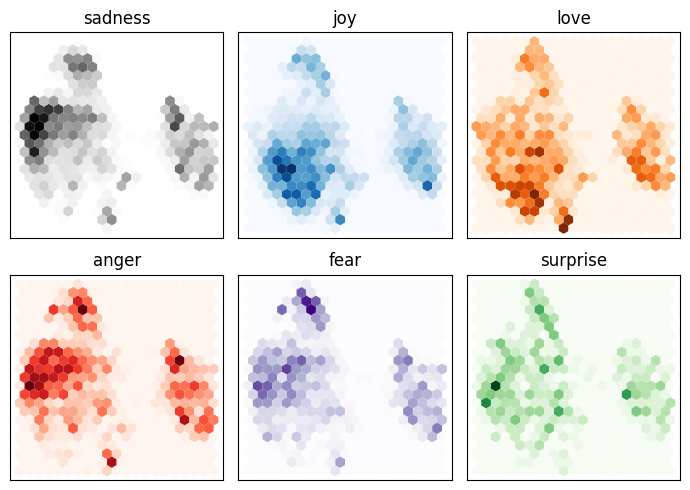

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
# Getting emotion labels
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  # Getting all the values for label from df
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(
    df_emb_sub["X"], # X point
    df_emb_sub["Y"], # Y point
    cmap=cmap,
    gridsize=20,
    linewidths=(0,)
  )
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show();

> Note: These are only projections onto a lower-dimensional space. Just because some categories overalap does not mean they are not seperable in the original space. Conversley, if they are seperable in the projected space will be seperable in original space.

#### Training a simple classifier

We've seen the hidden states are somewhat different between the emotions, although for several of them there is no obvious boundary. Let's use these hidden states to train a logistic regression model with Sxikit-learn. Training such a simple model is fast and does not require a GPU:

In [75]:
from sklearn.linear_model import LogisticRegression

# Increasing `max_iter` to gurantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

Looking at the accuracy, the model is just a bit better than random - since we are dealing with an unbalanced multiclass dataset. This might be better. Let's build a `DummyClassifier` baseline and compare it out.

`DummyClassifer` alway chooses mahority class or always draws a random class.

In our case majority is `joy`with 33%.

In [76]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

Comparing with the majority score, our simple classifier with DistillBERT embeddings is better than the baseline.

Let's look at the confusion matrix of the classifier,

In [77]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

In [78]:
y_preds = lr_clf.predict(X_valid)

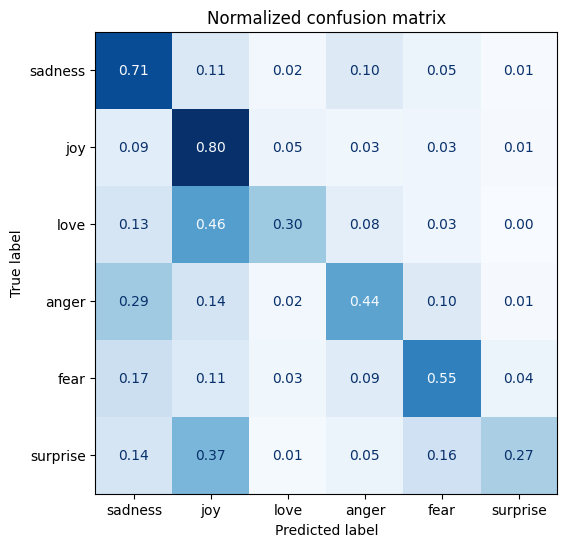

In [79]:
plot_confusion_matrix(y_preds, y_valid, labels)

* `anger` and `fear` are confused wit `sadness`, which was observed in embeddings.
* `love` and `surprise` are mistaken for `joy`.

When an GPU is not available, feature extraction might be a good compromise between traditional machine learning and deep learning.

## Fine-Tuning Transformers

Let's now explore how to fine-tune a transformer end-to-end.
In thia approach, hidden states are not freezed. Hence a classifier head is required as part of the network.

In [83]:
from torchinfo import summary

By training the hidden states which serves as inputs to the classification model, we may avoid working with data that may not be well suited for the classification task.

Instead hidden stated are tuned for the dataset and decresaes the model loss increasing the performance.

Let's use `Trainer` API to train the transformers.

### Loading a pretrained model

We've to load a model with classifier head from `auto-class`.
Let's use `AutoModelForSequenceClassification` instead of `AutoModel`.

The only input apart from checkpoint is to provide number of labels to predict.

In [84]:
from transformers import AutoModelForSequenceClassification

num_labels = len(labels)
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.

The classifiation head is initialized randomnly as it's not trained.

In [85]:
# Looking at the model architecutre
summary(model, col_names=["trainable"])

Layer (type:depth-idx)                                  Trainable
DistilBertForSequenceClassification                     True
├─DistilBertModel: 1-1                                  True
│    └─Embeddings: 2-1                                  True
│    │    └─Embedding: 3-1                              True
│    │    └─Embedding: 3-2                              True
│    │    └─LayerNorm: 3-3                              True
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 True
│    │    └─ModuleList: 3-5                             True
├─Linear: 1-2                                           True
├─Linear: 1-3                                           True
├─Dropout: 1-4                                          --
Total params: 66,958,086
Trainable params: 66,958,086
Non-trainable params: 0

### Defining the performance metrics

To monitor metrics durin training, we need to define a `compute_metrics()` function for the `Trainer`, This function recieves an `EvalPrediction` object (named tuple with `predictions` and `label_ids` attributes) and returns a dictonary with metric name and it's score.

In [86]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### Training the model

Before we train a model, we've to define `TrainingArguments` class. This class stores a lot of information and gives fine-grained control over training and evaluation.

In [ ]:
# TrainingArguments
from transformers import Trainer, TrainingArguments

batch_size = 64 # Batch size to train
logging_steps = len(emotions_encoded["train"]) // batch_size # Log every batch
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(
  output_dir=model_name, # output directory to store model artifacts
  num_train_epochs=2, # Training epochs
  learning_rate=2e-5, # Training learning rate
  per_device_train_batch_size=batch_size,  # Training batch size
  per_device_eval_batch_size=batch_size, #Eval batch size
  weight_decay=0.01, # Lr decay
  evaluation_strategy="epoch",
  disable_tqdm=False,
  logging_steps=logging_steps,
  push_to_hub=False,
  log_level="error",
)
training_args